In [1]:
import findspark
findspark.init()

In [2]:
import pyspark

In [3]:
sc=pyspark.SparkContext(appName="getARoom")

In [4]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()

In [5]:
df=spark.read.csv('getARoom/dataset/train.csv',header=True,inferSchema=True)

In [6]:
print(df)

DataFrame[Property_ID: string, Property_Type: string, Property_Area: int, Number_of_Windows: double, Number_of_Doors: int, Furnishing: string, Frequency_of_Powercuts: double, Power_Backup: string, Water_Supply: string, Traffic_Density_Score: double, Crime_Rate: string, Dust_and_Noise: string, Air_Quality_Index: double, Neighborhood_Review: double, Habitability_score: double]


In [7]:
df.show()

+-----------+------------------+-------------+-----------------+---------------+---------------+----------------------+------------+--------------------+---------------------+--------------------+--------------+-----------------+-------------------+------------------+
|Property_ID|     Property_Type|Property_Area|Number_of_Windows|Number_of_Doors|     Furnishing|Frequency_of_Powercuts|Power_Backup|        Water_Supply|Traffic_Density_Score|          Crime_Rate|Dust_and_Noise|Air_Quality_Index|Neighborhood_Review|Habitability_score|
+-----------+------------------+-------------+-----------------+---------------+---------------+----------------------+------------+--------------------+---------------------+--------------------+--------------+-----------------+-------------------+------------------+
|     0x21e3|         Apartment|          106|             null|              1| Semi_Furnished|                   0.0|          No|Once in a day - M...|                 5.89|Slightly below av.

In [8]:
df.describe()

DataFrame[summary: string, Property_ID: string, Property_Type: string, Property_Area: string, Number_of_Windows: string, Number_of_Doors: string, Furnishing: string, Frequency_of_Powercuts: string, Power_Backup: string, Water_Supply: string, Traffic_Density_Score: string, Crime_Rate: string, Dust_and_Noise: string, Air_Quality_Index: string, Neighborhood_Review: string, Habitability_score: string]

In [9]:
df.schema

StructType(List(StructField(Property_ID,StringType,true),StructField(Property_Type,StringType,true),StructField(Property_Area,IntegerType,true),StructField(Number_of_Windows,DoubleType,true),StructField(Number_of_Doors,IntegerType,true),StructField(Furnishing,StringType,true),StructField(Frequency_of_Powercuts,DoubleType,true),StructField(Power_Backup,StringType,true),StructField(Water_Supply,StringType,true),StructField(Traffic_Density_Score,DoubleType,true),StructField(Crime_Rate,StringType,true),StructField(Dust_and_Noise,StringType,true),StructField(Air_Quality_Index,DoubleType,true),StructField(Neighborhood_Review,DoubleType,true),StructField(Habitability_score,DoubleType,true)))

In [10]:
from pyspark.ml import Pipeline
from pyspark.ml.regression import DecisionTreeRegressor
from pyspark.ml.feature import VectorIndexer
from pyspark.ml.evaluation import RegressionEvaluator

In [12]:
# Split the data into training and test sets (30% held out for testing)
(trainingData, testData) = df.randomSplit([0.7, 0.3])

# Train a DecisionTree model.
#dt = DecisionTreeRegressor(featuresCol="Habitability_score")
# featureIndexer =\
#     VectorIndexer(inputCol="Traffic_Density_Score", outputCol="Habitability_score", maxCategories=4).fit(df)

In [13]:
trainingData.show()

+-----------+------------------+-------------+-----------------+---------------+---------------+----------------------+------------+--------------------+---------------------+--------------------+--------------+-----------------+-------------------+------------------+
|Property_ID|     Property_Type|Property_Area|Number_of_Windows|Number_of_Doors|     Furnishing|Frequency_of_Powercuts|Power_Backup|        Water_Supply|Traffic_Density_Score|          Crime_Rate|Dust_and_Noise|Air_Quality_Index|Neighborhood_Review|Habitability_score|
+-----------+------------------+-------------+-----------------+---------------+---------------+----------------------+------------+--------------------+---------------------+--------------------+--------------+-----------------+-------------------+------------------+
|     0x1000|Single-family home|         2115|              2.0|              3|    Unfurnished|                   0.0|          No|Once in a day - E...|                 4.49|  Well below avera

In [15]:
testData.show()

+-----------+------------------+-------------+-----------------+---------------+---------------+----------------------+------------+--------------------+---------------------+--------------------+--------------+-----------------+-------------------+------------------+
|Property_ID|     Property_Type|Property_Area|Number_of_Windows|Number_of_Doors|     Furnishing|Frequency_of_Powercuts|Power_Backup|        Water_Supply|Traffic_Density_Score|          Crime_Rate|Dust_and_Noise|Air_Quality_Index|Neighborhood_Review|Habitability_score|
+-----------+------------------+-------------+-----------------+---------------+---------------+----------------------+------------+--------------------+---------------------+--------------------+--------------+-----------------+-------------------+------------------+
|     0x1001|         Apartment|          581|              4.0|              3| Semi_Furnished|                   0.0|          No|Once in a day - E...|                 7.89|  Well below avera

In [ ]:
from collections import defaultdict

data_types=defaultdict(list)
for entry in df.schema.fields:
    data_types[str(entry.dataType)].append(entry.name)    
print(data_types)

In [ ]:
strings_used = [var for var in data_types["StringType"]]
missing_data_fill = {}
for var in strings_used:
    missing_data_fill[var] = "missing"

df = df.fillna(missing_data_fill)

In [ ]:
from pyspark.ml.feature import Imputer

In [ ]:
from pyspark.sql.functions import when, col
df2=df.withColumn('Number_of_Windows_out', 
                  when(df.Number_of_Windows.isNotNull() , df.Number_of_Windows)
                  .when(df.Number_of_Windows.isNull() , df.Number_of_Doors+1))
df2=df2.withColumn('Frequency_of_Powercuts_out', 
               when(df.Frequency_of_Powercuts.isNull(),0)
               .otherwise(df.Frequency_of_Powercuts))
df2=df2.drop('Number_of_Windows')
df2=df2.drop('Frequency_of_Powercuts')
#df2=df2.withColumn('Frequency_of_Powercuts_out', 
#               when(df.Frequency_of_Powercuts.isNull(),0)
#               .otherwise(df.Frequency_of_Powercuts))

df2.show()

In [ ]:
#spark.stop()

In [ ]:
#sc.stop()

from pyspark.ml import Pipeline
from pyspark.ml.regression import DecisionTreeRegressor
from pyspark.ml.feature import VectorIndexer
from pyspark.ml.evaluation import RegressionEvaluator

# Load the data stored in LIBSVM format as a DataFrame.
data = spark.read.format("libsvm").load("data/mllib/sample_libsvm_data.txt")

# Automatically identify categorical features, and index them.
# We specify maxCategories so features with > 4 distinct values are treated as continuous.
featureIndexer =\
    VectorIndexer(inputCol="features", outputCol="indexedFeatures", maxCategories=4).fit(data)

# Split the data into training and test sets (30% held out for testing)
(trainingData, testData) = data.randomSplit([0.7, 0.3])

# Train a DecisionTree model.
dt = DecisionTreeRegressor(featuresCol="indexedFeatures")

# Chain indexer and tree in a Pipeline
pipeline = Pipeline(stages=[featureIndexer, dt])

# Train model.  This also runs the indexer.
model = pipeline.fit(trainingData)

# Make predictions.
predictions = model.transform(testData)

# Select example rows to display.
predictions.select("prediction", "label", "features").show(20)

# Select (prediction, true label) and compute test error
evaluator = RegressionEvaluator(
    labelCol="label", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

treeModel = model.stages[1]
# summary only
print(treeModel)

# Select example rows to display.
predictions.select("prediction", "label", "features").show(20)

# Select (prediction, true label) and compute test error
evaluator = RegressionEvaluator(
    labelCol="label", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

treeModel = model.stages[1]
# summary only
print(treeModel)

In [55]:
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
from collections import defaultdict
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split


In [105]:
df=pd.read_csv('getARoom/dataset/train.csv')
df.describe(include='all')

,Property_ID,Property_Type,Property_Area,Number_of_Windows,Number_of_Doors,Furnishing,Frequency_of_Powercuts,Power_Backup,Water_Supply,Traffic_Density_Score,Crime_Rate,Dust_and_Noise,Air_Quality_Index,Neighborhood_Review,Habitability_score
count,39499,39499,39499.000000,37845.000000,39499.000000,38457,38116.000000,39499,39499,39499.000000,38712,38280,39499.000000,39499.000000,39499.000000
unique,39499,6,NaN,NaN,NaN,3,NaN,3,5,NaN,4,3,NaN,NaN,NaN
top,0x21e3,Apartment,NaN,NaN,NaN,Semi_Furnished,NaN,No,All time,NaN,Well below average,Medium,NaN,NaN,NaN
freq,1,14596,NaN,NaN,NaN,20357,NaN,29714,19511,NaN,19472,32996,NaN,NaN,NaN
mean,NaN,NaN,1391.715638,3.923768,2.331375,NaN,0.484678,NaN,NaN,6.354772,NaN,NaN,121.352566,3.735945,73.482297
std,NaN,NaN,1953.287544,2.690992,1.179964,NaN,0.752207,NaN,NaN,1.219681,NaN,NaN,62.384669,0.796843,14.118753
min,NaN,NaN,100.000000,0.000000,1.000000,NaN,0.000000,NaN,NaN,0.000000,NaN,NaN,0.000000,0.000000,7.280000
25%,NaN,NaN,494.000000,2.000000,1.000000,NaN,0.000000,NaN,NaN,5.600000,NaN,NaN,95.000000,3.220000,69.660000
50%,NaN,NaN,932.000000,4.000000,2.000000,NaN,0.000000,NaN,NaN,6.470000,NaN,NaN,113.000000,3.850000,75.760000
75%,NaN,NaN,1770.000000,5.000000,3.000000,NaN,1.000000,NaN,NaN,7.220000,NaN,NaN,140.000000,4.260000,82.260000


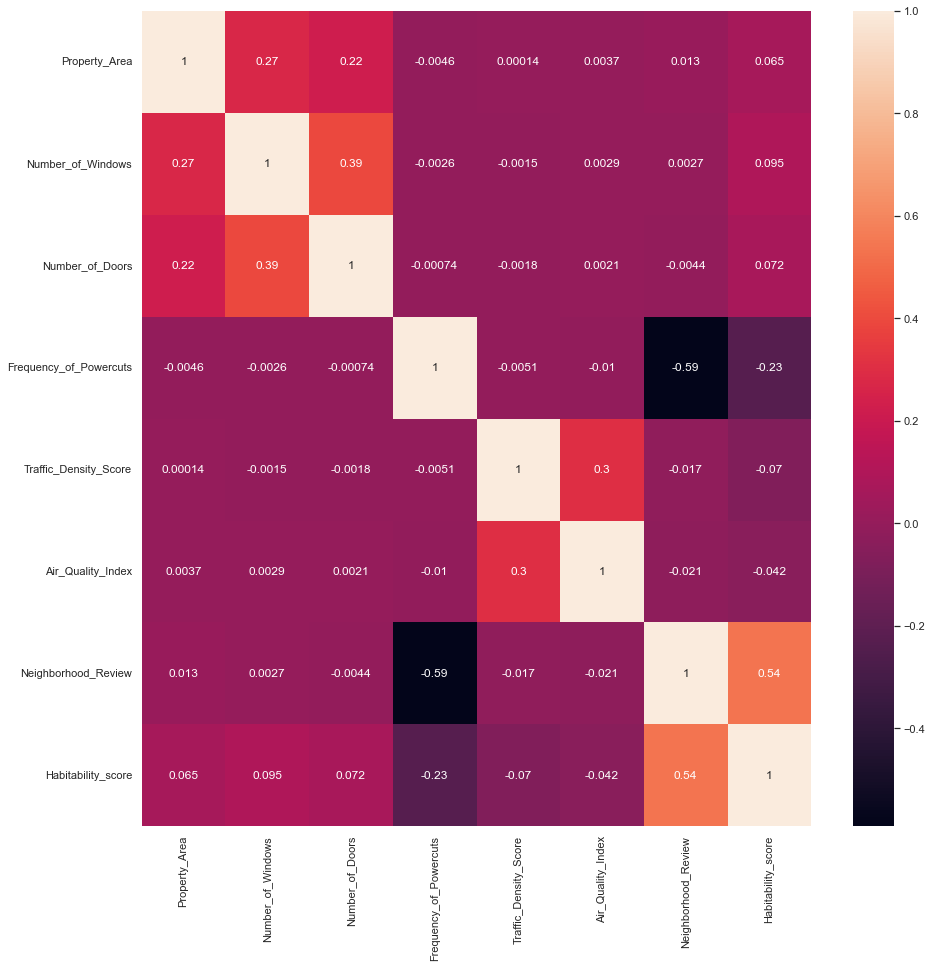

In [106]:
matrix=df.corr()
sn.heatmap(matrix, annot=True)
plt.show()

In [107]:
data_types=defaultdict(list)
for entry in df.columns:
    data_types[str(df[entry].dtypes)].append(entry)    
print(data_types)

defaultdict(<class 'list'>, {'object': ['Property_ID', 'Property_Type', 'Furnishing', 'Power_Backup', 'Water_Supply', 'Crime_Rate', 'Dust_and_Noise'], 'int64': ['Property_Area', 'Number_of_Doors'], 'float64': ['Number_of_Windows', 'Frequency_of_Powercuts', 'Traffic_Density_Score', 'Air_Quality_Index', 'Neighborhood_Review', 'Habitability_score']})


In [108]:
strings_used = [var for var in data_types["object"]]
missing_data_fill = {'Furnishing':'Unfurnished','Crime_Rate':'Slightly above average','Dust_and_Noise':'Medium'}
df = df.fillna(missing_data_fill)

In [109]:
le=LabelEncoder()
df['Property_ID']=le.fit_transform(df['Property_ID'])


In [110]:
for var in strings_used:
    if var not in ['Property_ID']:
        df[var]=le.fit_transform(df[var])

'''
#Property_Type
le=le.fit(['#R%$G&867','Container Home','Single-family home','Apartment','Duplex','Bungalow'])
df['Property_Type']=le.transform(df['Property_Type'])

le=le.fit(['missing','Unfurnished','Semi_Furnished','Fully Furnished'])
df['Furnishing']=le.transform(df['Furnishing'])

le=le.fit(['No','NOT MENTIONED','Yes'])
df['Power_Backup']=le.transform(df['Power_Backup'])

le=le.fit(['NOT MENTIONED','Once in two days','Once in a day - Evening','Once in a day - Morning','All time'])
df['Water_Supply']=le.transform(df['Water_Supply'])

le=le.fit(['missing','Well above average','Slightly above average','Slightly below average','Well below average'])
df['Crime_Rate']=le.transform(df['Crime_Rate'])

le=le.fit(['High','missing','Medium','Low'])
df['Dust_and_Noise']=le.transform(df['Dust_and_Noise'])
'''

"\n#Property_Type\nle=le.fit(['#R%$G&867','Container Home','Single-family home','Apartment','Duplex','Bungalow'])\ndf['Property_Type']=le.transform(df['Property_Type'])\n\nle=le.fit(['missing','Unfurnished','Semi_Furnished','Fully Furnished'])\ndf['Furnishing']=le.transform(df['Furnishing'])\n\nle=le.fit(['No','NOT MENTIONED','Yes'])\ndf['Power_Backup']=le.transform(df['Power_Backup'])\n\nle=le.fit(['NOT MENTIONED','Once in two days','Once in a day - Evening','Once in a day - Morning','All time'])\ndf['Water_Supply']=le.transform(df['Water_Supply'])\n\nle=le.fit(['missing','Well above average','Slightly above average','Slightly below average','Well below average'])\ndf['Crime_Rate']=le.transform(df['Crime_Rate'])\n\nle=le.fit(['High','missing','Medium','Low'])\ndf['Dust_and_Noise']=le.transform(df['Dust_and_Noise'])\n"

In [111]:
for var in strings_used:
    print(df[var].value_counts())

3577     1
29795    1
26927    1
28044    1
31381    1
        ..
18352    1
29506    1
25485    1
517      1
25693    1
Name: Property_ID, Length: 39499, dtype: int64
1    14596
5    11477
4     5806
2     4238
3     2872
0      510
Name: Property_Type, dtype: int64
1    20357
2    11386
0     7756
Name: Furnishing, dtype: int64
1    29714
2     8957
0      828
Name: Power_Backup, dtype: int64
0    19511
3     9897
2     7815
4     1931
1      345
Name: Water_Supply, dtype: int64
3    19472
1    11580
0     6090
2     2357
Name: Crime_Rate, dtype: int64
2    34215
0     3212
1     2072
Name: Dust_and_Noise, dtype: int64


In [112]:
df['Number_of_Windows']=df['Number_of_Windows'].fillna(df['Number_of_Doors']+1)
df['Frequency_of_Powercuts']=df['Frequency_of_Powercuts'].fillna(0)

In [113]:
df.describe(include='all')

,Property_ID,Property_Type,Property_Area,Number_of_Windows,Number_of_Doors,Furnishing,Frequency_of_Powercuts,Power_Backup,Water_Supply,Traffic_Density_Score,Crime_Rate,Dust_and_Noise,Air_Quality_Index,Neighborhood_Review,Habitability_score
count,39499.000000,39499.000000,39499.000000,39499.000000,39499.000000,39499.000000,39499.000000,39499.000000,39499.000000,39499.000000,39499.000000,39499.000000,39499.000000,39499.000000,39499.000000
mean,19749.000000,2.843034,1391.715638,3.895921,2.331375,1.091901,0.467708,1.205803,1.351680,6.354772,1.891440,1.784906,121.352566,3.735945,73.482297
std,11402.523478,1.728091,1953.287544,2.647775,1.179964,0.690062,0.744272,0.453187,1.417895,1.219681,1.179458,0.575738,62.384669,0.796843,14.118753
min,0.000000,0.000000,100.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.280000
25%,9874.500000,1.000000,494.000000,2.000000,1.000000,1.000000,0.000000,1.000000,0.000000,5.600000,1.000000,2.000000,95.000000,3.220000,69.660000
50%,19749.000000,3.000000,932.000000,3.000000,2.000000,1.000000,0.000000,1.000000,1.000000,6.470000,2.000000,2.000000,113.000000,3.850000,75.760000
75%,29623.500000,5.000000,1770.000000,5.000000,3.000000,2.000000,1.000000,1.000000,3.000000,7.220000,3.000000,2.000000,140.000000,4.260000,82.260000
max,39498.000000,5.000000,28064.000000,15.000000,6.000000,2.000000,3.000000,2.000000,4.000000,9.910000,3.000000,2.000000,1044.000000,5.000000,100.000000


<AxesSubplot:>

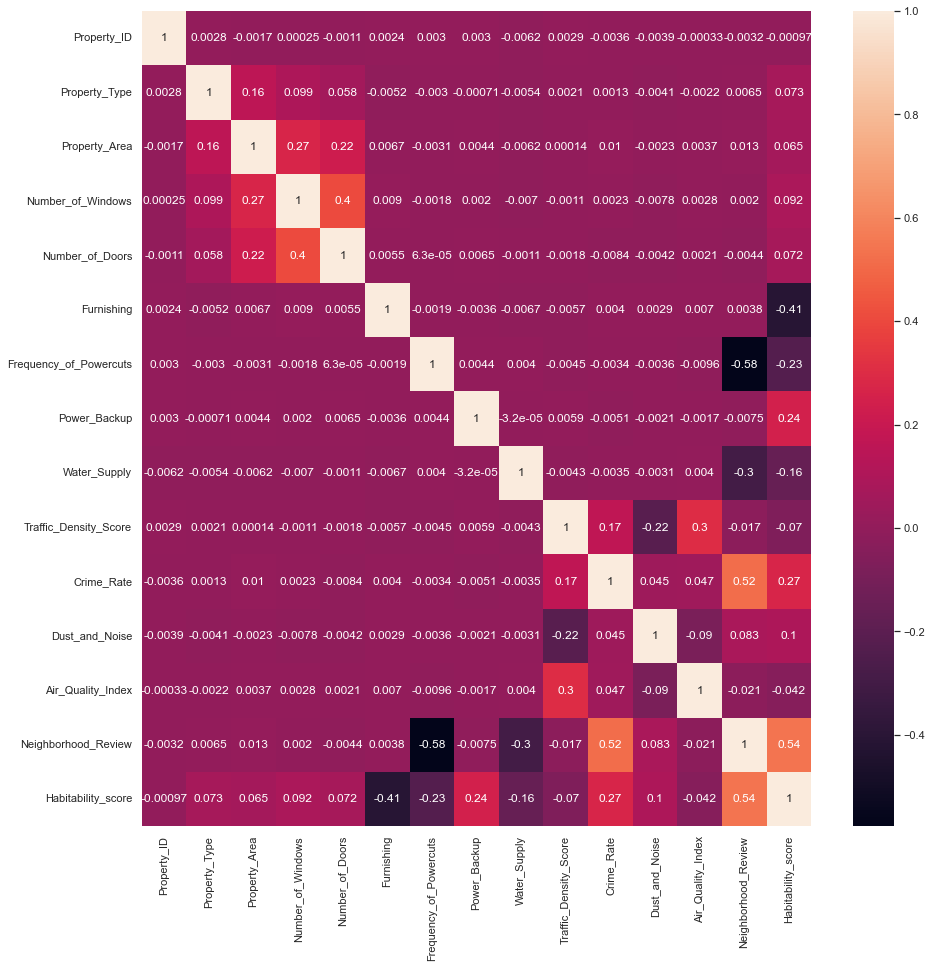

In [114]:
matrix=df.corr()
sn.set(rc = {'figure.figsize':(15,15)})

sn.heatmap(matrix, annot=True)
#plt.show()

In [121]:
X=df.iloc[:,1:-1]#.loc[:,['Frequency_of_Powercuts', 'Neighborhood_Review']]

In [133]:
y=df.loc[:,['Habitability_score']]

In [134]:
X_train, X_test, y_train, y_test=train_test_split(X,y)

In [137]:
from sklearn.linear_model import ElasticNet

In [141]:
model=LinearRegression().fit(X_train, y_train)
#model=ElasticNet(alpha=1.0, l1_ratio=0.5).fit(X_train, y_train)


In [142]:
model.predict(X_test)

array([[68.35767385],
       [69.77680257],
       [64.44193128],
       ...,
       [47.39633402],
       [81.15071508],
       [68.67706516]])

In [143]:
model.score(X_test,y_test)

0.549179975775894